# Webex Teams Guest Issuer API Tutorial

### What you learned previously?
Previously in the first notebook we learned how to perform authentication using the client API. We used OAuth-2 Authentication and exchanged code with access token. 

<br />
In this tutorial we will create a Guest Issuer token and create a simple messaging system where **guest** is allowed to send and view messages. We will follow the following steps:

1. Create a Guest Issuer App.
2. Authenticate Guest.
3. Create a Messaging System.

So Lets begin.



## 1. Create a Guest Issuer App

As a Webex developer, what if you want to interact with users who do not have a Webex account? These users may be visitors to a website who you'd like to message with over Webex. Or they may be customers in a store you’d like to have a video call with. These guest users can interact with regular Webex users via tokens generated by a Guest Issuer application.

Like in previous guide, please log in to your Developer account, click on your account on the top right hand side as shown in Figure.


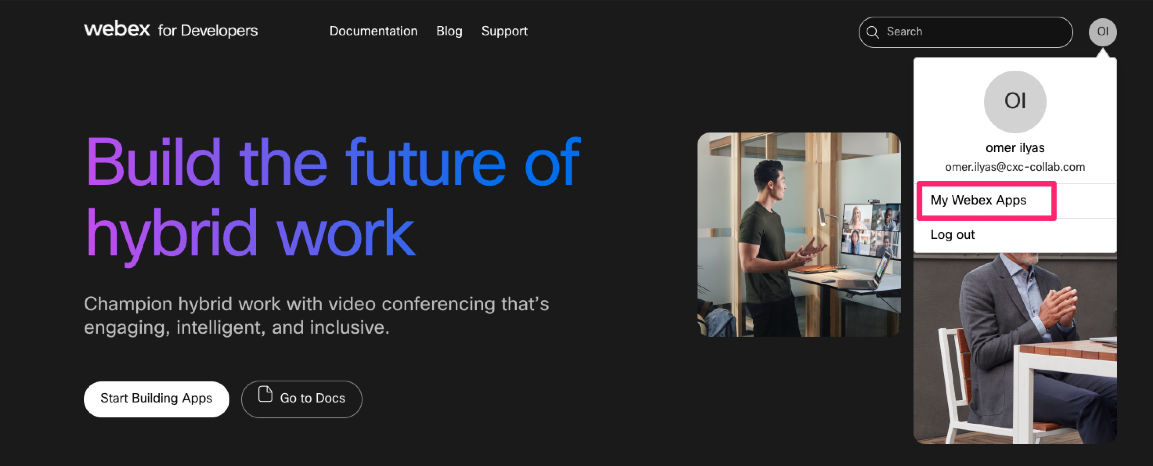

Click on My Webex Apps. This will prompt you to the Apps page. You might have one app created from previous exercise. So lets start by creating one. Click on **Create Guest Issuer**.

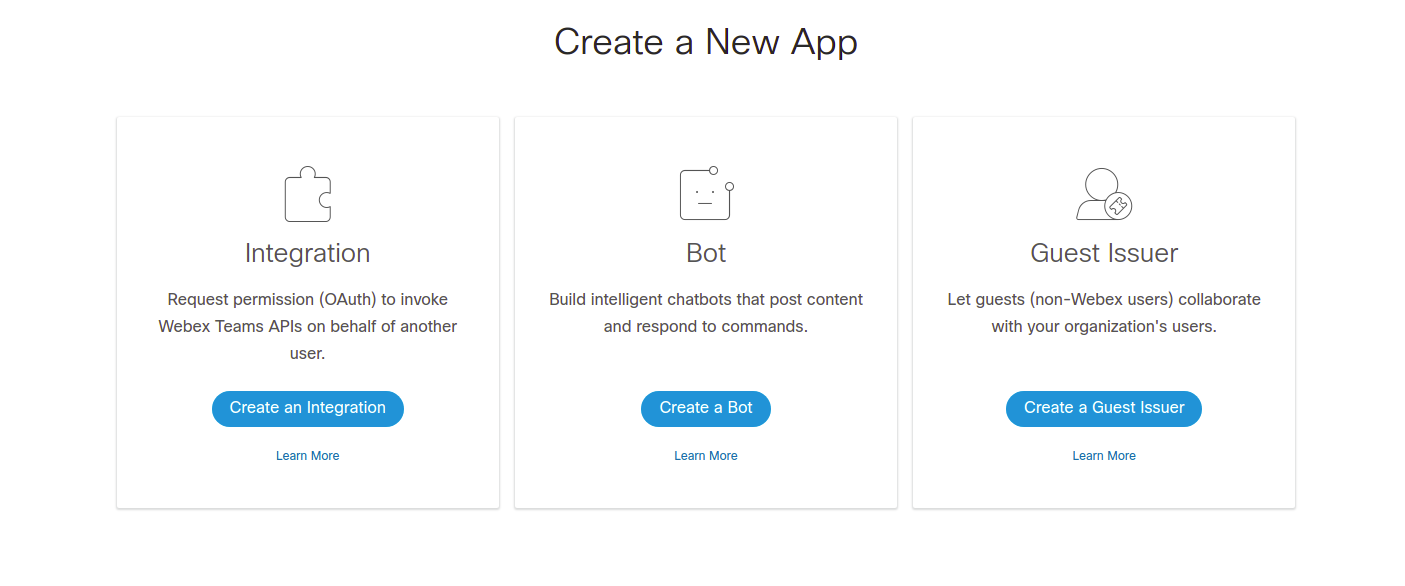

The only thing you have to provide is a Guest Issuer App Name. For this tutorial we can use **Omer Guest** as the app name.
Now copy the **Guest Issuer ID** and **Shared Secret** as they will be used in the next step for authentication.

## 2. Authenticate Guest

Unlike previous authentication (OAuth-2) you saw in the first notebook, guest tokens uses JWT Authentication. 

### What is JWT?
According to wikipedia, "JSON Web Token (JWT) is an Internet proposed standard for creating data with optional signature and/or optional encryption whose payload holds JSON that asserts some number of claims." But thats really difficult to understand, isn't it? So at this point what you need to know is that it is a standard that encrypts a payload (any JSON message) with a public or private encryption key. That's it.

<br />

Gladly geeks of python have established a library to handle JWT Authentication for which we are really thankful (Jeff Lindsay: https://github.com/progrium).

In [ ]:
# import necessary libraries
import jwt
import base64
import datetime
import requests
import json

In [ ]:
issuer_id = '' # Paste your Guest issuer id here
secret_enc = ''  #  Paste your Shared Secret here.The shared secret that was created above is already encoded with base64 standard
guest_name = 'Guest 001'
unique_title = 'guest-user-001'

In [ ]:
# This is predefine
header = {
  "typ": "JWT",  # standard is jwt. Type has to be JWT 
  "alg": "HS256"  # encryption is hash256. Hashing algorithm Must be HS256.
}

payload = {
  "sub": unique_title,  # your guest title (should be unique)
  "name": guest_name,  # name of your guest
  "iss": issuer_id,
  # this is the expiry time in unix time stamp(which you don't need to worry about)
  "exp": datetime.datetime.utcnow() + datetime.timedelta(seconds=30)  # expiry time is 30 seconds from now. Use the lowest practical value for the use of the token
}

<div class="alert alert-block alert-success">
    To create the signature, the encoded header and payload, along with the secret (provided when the app is created) are combined and signed using the algorithm specified in the header.
   </div>

In [ ]:
encoded = jwt.encode(payload, secret, algorithm="HS256", headers=header)
encoded = encoded.decode("utf-8")
# The following code in this block is for learning only
print('Individual Parts: \n')
encoded_temp = encoded.split('.')
print (encoded_temp)
for e in encoded_temp:
    print(e)

# print('\nParts are joined with "." to create a complete token.')
print('\n\nComplete Token: ')
print(encoded)

Now lets exchange this token for an access key that can be used for WebEx Client services.

The services limited to guests are:
1. Send Message on Person Email.
2. Recieve Message in Room.

<div class="alert alert-block alert-info">
<b>Note:</b> The Webex SDKs handle the guest token exchange and authentication for you, but as we aren't using Webex SDK,and  need more control over the authentication process, we will use REST API to exchange a guest token for an access token. You can then use the access token to make API requests like you would with a bot token or integration token.
</div>


In [ ]:
url = 'https://webexapis.com/v1/jwt/login'
headers = {'Authorization' : f'Bearer {encoded}'}

# Send a Post Request
r = requests.post(url, headers=headers)

# use the json() method of the response object to get the response
print(json.dumps(r.json(), indent=4, sort_keys=True))

token = r.json()['token']

<div class="alert alert-block alert-info">
<b>Note:</b> In this example, the access token will be valid for almost six hours. The expiration (exp) claim in the guest token will not affect this expiration time.
</div>

Lets see if there are any rooms available to this guest. Hopefully there won't be, as we have not chatted with anyone yet. But lets ensure that.

In [ ]:
url = 'https://webexapis.com/v1/rooms'

# authorization is achieved by passing the access token in an authorization header
headers = {'Authorization' : f'Bearer {token}',
          'Content-type' : 'application/json; charset=utf-8'}

r = requests.get(url, headers=headers)

# raise an exception in case the request failed
r.raise_for_status()

# use the json() method of the response object to get the response
print(json.dumps(r.json(), indent=4, sort_keys=True))

There aren't any rooms yet. So lets create one by initializing a chat with ourself.

In [ ]:
email_id = ''  # enter your webex app email id here, the user you want to send message to.

headers = {
    'Authorization' : f'Bearer {token}',
    'Content-Type' : 'application/json; charset=utf-8'
    }

url = 'https://webexapis.com/v1/messages'

params = {
    'toPersonEmail' : email_id,
    'text' : 'This is a guest user.'
}

# the endpoint requires a POST and the parameters are passed as JSON in the body
r = requests.post(url, json=params, headers=headers)
print(json.dumps(r.json(), indent=4, sort_keys=True))

Now lets check how many rooms are there

In [ ]:
url = 'https://webexapis.com/v1/rooms'

# authorization is achieved by passing the access token in an authorization header
headers = {'Authorization' : f'Bearer {token}',
          'Content-type' : 'application/json; charset=utf-8'}

r = requests.get(url, headers=headers)

# raise an exception in case the request failed
r.raise_for_status()

# use the json() method of the response object to get the response
print(json.dumps(r.json(), indent=4, sort_keys=True))

roomId = r.json()['items'][0]['id']

<div class="alert alert-block alert-success">Perfect! We have created a room now.

**Note:** If you open your Teams App now, it will show you the chat from guest. You can also reply to our newly created guest user as explained in below section.
</div>

## 3. Create a Simple Messaging System

Lets create a simple messaging system which will allow us to send messages and display them in a way that is compact and clear.

<div class="alert alert-block alert-danger">
<b>Note:</b> This is a test function only, it creates a method that allow to send messages via API. As the code is only running when we executing our notebook, to see messages back and forth please feel free to run the code as needed.

In [ ]:
def send_message(msg):
  headers = {
    'Authorization' : f'Bearer {token}',
    'Content-Type' : 'application/json; charset=utf-8'
    }

  params = {
      'roomId' : roomId,
      'text' : msg
  }

  url = 'https://webexapis.com/v1/messages'

  r = requests.post(url, json=params, headers=headers)

  params = {
    'roomId' : roomId
  }
  r = requests.get(url, params=params, headers=headers)

  r = r.json()
  for entry in r['items']:
    print(f"{entry['personEmail']} : {entry['text']}")

In [ ]:
send_message('Testing API') #  Feel free to write any thing in here. the message typed here will be seen in Webex app when executed

<div class="alert alert-block alert-success">
    This conclude the section of the guide.
</div>

### REFERENCES -  APIs used in this notebook

<a href="https://developer.webex.com/docs/guest-issuer">Understand Guest Issuer tokens</a>

<a href="https://developer.webex.com/docs/api/v1/people"> People API</a>

<a href="https://developer.webex.com/docs/api/v1/messages"> Messages API </a>

<a href="https://developer.webex.com/docs/api/v1/rooms/list-rooms"> Room API </a>